In [ ]:
import torch
from torch import nn
import math
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import numpy as np
import copy

In [ ]:
torch.manual_seed(473)
device=""
if torch.cuda.is_available():
    device=torch.device("cuda")
else:
    device=torch.device("cpu")
device

device(type='cuda')

In [ ]:
def dataextract(n,tset):
  itt=iter(tset)
  DATA=[]
  for i in range(len(tset)):
    K=next(itt)
    if K[1] in n:
      DATA.append((K[0],K[1]))
  return DATA

def plotter(model,dataloader,n):
  iterr=iter(dataloader)
  for i in range(n**2):
    img,lbl=next(iterr)
    with torch.no_grad():
      out=model(img[i].view(1,28*28))
    pred=torch.exp(out).numpy().argmax(axis=1)
    ax=plt.subplot(n,n,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img[i].reshape(28,28),cmap='gray')
    tit='C: '+str(lbl.numpy()[i])+"; P: "+str(pred)
    plt.title(tit)




In [ ]:
class Noise(nn.Module):
    def __init__(self, *dim):
        super().__init__()
        self.noise = torch.nn.Parameter(torch.randn(*dim), requires_grad = True)

    def forward(self):
        return self.noise

def noisewrapper(noises,batchsize,imgshape,forgetclasses):
  NOISE={}
  ims=28 #int(imgshape**0.5)
  for cls in forgetclasses:
    temp=noises[cls]().cpu().detach().reshape((batchsize,1,ims,ims))
    data=[]
    for i in range(batchsize):
      data.append((temp[i],cls))
    NOISE[cls]=Customdata([cls],data,transform=transform)
  return NOISE


def getnoises(batchsize,imgshape,forgetclasses,model):
  noises={}
  for cls in forgetclasses:
    print("Generating noise for class {}".format(cls))
    noises[cls]=Noise(batchsize,imgshape)
    lr=0.01
    momentum=0.9
    #opt=torch.optim.Adam(noises[cls].parameters(),lr=0.1)
    opt=torch.optim.SGD(noises[cls].parameters(),lr=lr,momentum=momentum)
    lossfunction=nn.NLLLoss()
    numepoch=5
    numsteps=10
    for epoch in range(numepoch):
      totalloss=[]
      for batch in range(numsteps):
        #print('a')
        inputs=noises[cls]()
        labels=torch.zeros(batchsize)+cls
        #with torch.no_grad():
        outputs=model(inputs)
        out=outputs
        opt.zero_grad()
        #out=torch.zeros(batchsize)
        #for i in range(batchsize):
          #print(torch.exp(outputs[i]).numpy().argmax(axis=0))
        #  out[i]=out[i]+torch.exp(outputs[i]).numpy().argmax(axis=0)#outputs[i].argmax(axis=0)
        #print(str((out,labels)))
        #with torch.no_grad():
        #print(labels.shape)
        #print(out.shape)
        #print(lossfunction(out,labels.long()))
        #print('aas')
          #print(nn.NLLLoss(out[i],labels[i]).shape)\
        loss=-lossfunction(out,labels.long())+ 0.1*torch.mean(torch.sum(torch.square(inputs),axis=1))

        loss.backward()
        opt.step()
        #totalloss.append(loss)
      #with torch.no_grad():
      #  print("Loss: {}".format(np.mean(totalloss)))
  return noisewrapper(noises,batchsize,imgshape,forgetclasses)

def datasetcustom(N,dataset):
  DATA=[]
  n=[0,1,2,3,4,5,6,8,9]
  itter=iter(dataset)
  for i in range(N):
    img,lbl=next(itter)
    DATA.append((img,lbl))
  DATA=Customdata(n,DATA)
  return DATA

In [ ]:



class Customdata(torch.utils.data.Dataset):
  def __init__(self,n,tset,transform=None):
    self.dat=dataextract(n,tset)
    self.transform=transform
  def __len__(self):
    return len(self.dat)
  def __getitem__(self,index):
    #if self.transform:
    #  img=self.transform(self.dat[index][0])
    return (self.dat[index][0],self.dat[index][1])

class MNIST(nn.Module):
  def __init__(self,inputsize,hiddenlsize):
    super().__init__()
    self.model=nn.Sequential(nn.Linear(inputsize,hiddenlsize[0]),nn.ReLU(),
                             nn.Linear(hiddenlsize[0],hiddenlsize[1]),nn.ReLU(),
                             nn.Linear(hiddenlsize[1],10),nn.LogSoftmax(dim=1))
  def forward(self,x):
    output=self.model(x)
    return output

  def trainer(self,dataloader):
    epochs=5
    lr=0.003
    momentum=0.9
    lossfunction=nn.NLLLoss()#for classifying problems with 'c' number of classes
    optimizer=torch.optim.SGD(self.model.parameters(),lr=lr,momentum=momentum)
    for i in range(epochs):
      runningloss=0
      for images,labels in dataloader:
        images=images.view(images.shape[0],-1)#tensor from [batchsize,1,28,28] to [batchsize,28*28] ==> flatten images

        optimizer.zero_grad()
        out=self.model(images)#applies model to each image in batch and return label list for the batch
        #print('a')
        #print(out.shape)
        #print(labels.shape)
        loss=lossfunction(out,labels)#each image in batch==> {out[i][0],out[i][1]...out[i][c] }==> should have class given in labels[i] i.e out[i][labels[i]] should be 1
        loss.backward()
        optimizer.step()

        runningloss += loss.item()
      print("epoch: "+str(i)+" : loss= "+str(runningloss))

  def tester(self,dataloader):
    correct,all=0,0
    for images,labels in dataloader:
      for i in range(len(labels)):
        img=images[i].view(1,28*28)
        with torch.no_grad():
          outs=self.model(img)
        pred=torch.exp(outs).numpy().argmax(axis=1)
        if pred== labels.numpy()[i]:
          correct +=1
        all +=1
    print("All= "+str(all)+"; correct= "+str(correct)+"; Accuracy= "+str(correct/all))

  def unlearn(self,classtoforget,dataloader):
    images,labels =next(iter(dataloader))
    images=images.view(images.shape[0],-1)
    batchsize,imgshape=images.shape[0],images.shape[1]
    noises=getnoises(batchsize,imgshape,classtoforget,self.model)
    return noises


In [ ]:
def getnoisydata(noise,forgetclasses,dataset):
  DATA=[]
  itter=iter(dataset)
  n=[0,1,2,3,4,5,6,8,9]
  for i in range(1000):
    img,lbl=next(itter)
    DATA.append((img,lbl))
  DATA=Customdata(n,DATA)
  res=torch.utils.data.ConcatDataset([DATA])
  for cls in forgetclasses:
    res=torch.utils.data.ConcatDataset([res, noise[cls]])
  return res

In [ ]:
batch_size=32
#train_loader=torch.utils.data.DataLoader(train_set,batch_size=batch_size,shuffle=True)

transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))])
trainset=torchvision.datasets.MNIST(root=".",train=True,download=True,transform=transform)
testset=torchvision.datasets.MNIST(root=".",train=False,download=True,transform=transform)



smalltrainset=datasetcustom(100,trainset)
smalltrainloader=torch.utils.data.DataLoader(smalltrainset)

100%|██████████| 9912422/9912422 [00:00<00:00, 251603464.26it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 23982517.09it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 86704420.50it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 4458349.82it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
trainloader=torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=True)
testloader=torch.utils.data.DataLoader(testset,batch_size=batch_size,shuffle=True)

In [ ]:
train7=Customdata([7],trainset)
train7loader=torch.utils.data.DataLoader(train7,batch_size=batch_size,shuffle=True)

In [ ]:
imgs,labels=next(iter(trainloader))
imgs=imgs.view(imgs.shape[0],-1)
model=MNIST(imgs.shape[1],[128,64])

In [ ]:
model.tester(train7loader)
model.tester(testloader)

All= 6265; correct= 0; Accuracy= 0.0
All= 10000; correct= 1098; Accuracy= 0.1098


In [ ]:
model.parameters

<bound method Module.parameters of MNIST(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
    (5): LogSoftmax(dim=1)
  )
)>

In [ ]:
p=next(iter(model.parameters()))

In [ ]:
p.shape

torch.Size([128, 784])

In [ ]:
model.trainer(trainloader)

epoch: 0 : loss= 910.0454649217427
epoch: 1 : loss= 401.83302163146436
epoch: 2 : loss= 288.8068881770596
epoch: 3 : loss= 230.59889195347205
epoch: 4 : loss= 190.9328230251558


In [ ]:
model.tester(train7loader)
model.tester(testloader)

All= 6265; correct= 6164; Accuracy= 0.9838786911412609
All= 10000; correct= 9658; Accuracy= 0.9658


In [ ]:
##################################################################################

In [ ]:

class mymnist(nn.Module):
  def __init__(self,inputsize,hiddenlsize):
    super().__init__()
    self.firstlayer=nn.Linear(inputsize,hiddenlsize[0])
    self.firstactive=nn.ReLU()
    self.secondlayer=nn.Linear(hiddenlsize[0],hiddenlsize[1])
    self.secondactive=nn.ReLU()
    self.thirdlayer=nn.Linear(hiddenlsize[1],10)
    self.final=nn.LogSoftmax()



  def forward(self,x):
    out=self.firstlayer(x)
    out=self.firstactive(out)
    out=self.secondlayer(out)
    out=self.secondactive(out)
    out=self.thirdlayer(out)
    out=self.final(out)

    return out

  def trainer(self,dataloader):
    epochs=5
    lr=0.003
    momentum=0.9
    lossfunction=nn.NLLLoss()#for classifying problems with 'c' number of classes
    optimizer=torch.optim.SGD(self.parameters(),lr=lr,momentum=momentum)
    for i in range(epochs):
      runningloss=0
      for images,labels in dataloader:
        images=images.view(images.shape[0],-1)#tensor from [batchsize,1,28,28] to [batchsize,28*28] ==> flatten images

        optimizer.zero_grad()
        out=self(images)#applies model to each image in batch and return label list for the batch
        #print('a')
        #print(out.shape)
        #print(labels.shape)
        loss=lossfunction(out,labels)#each image in batch==> {out[i][0],out[i][1]...out[i][c] }==> should have class given in labels[i] i.e out[i][labels[i]] should be 1
        loss.backward()
        optimizer.step()

        runningloss += loss.item()
      print("epoch: "+str(i)+" : loss= "+str(runningloss))

  def tester(self,dataloader):
    correct,all=0,0
    for images,labels in dataloader:
      for i in range(len(labels)):
        img=images[i].view(1,28*28)
        with torch.no_grad():
          outs=self(img)
        pred=torch.exp(outs).numpy().argmax(axis=1)
        if pred== labels.numpy()[i]:
          correct +=1
        all +=1
    print("All= "+str(all)+"; correct= "+str(correct)+"; Accuracy= "+str(correct/all))

  def visulaiser(self,dataloader):
    L1his=[]
    L2his=[]
    for images, labels in dataloader:
      for i in range(len(labels)):
        img=images[i].view(1,28*28)
        with torch.no_grad():
          outs=self.firstactive(self.firstlayer(img))
          l1=outs[0].numpy()
          outs=self.secondactive(self.secondlayer(outs))
          l2=outs[0].numpy()
          outs=self.final(self.thirdlayer(outs))
          l3=np.zeros(10)
          l3[torch.exp(outs[0]).numpy().argmax(axis=0)]=1
          #print(l3)
          LAYER1=[[],[]]
          LAYER2=[[],[]]
          LAYER3=[[],[]]
          for j in range(len(l1)):
            if l1[j]>0:
              LAYER1[0].append(-1)
              LAYER1[1].append(j*2)
          for j in range(len(l2)):
            if l2[j]>0:
              LAYER2[0].append(1)
              LAYER2[1].append(j*4)
          for j in range(len(l3)):
            if l3[j]>0:
              LAYER3[0].append(2)
              LAYER3[1].append(j)
          s,al=2.5,1
          if torch.exp(outs[0]).numpy().argmax(axis=0)==labels[i]:
            #plt.scatter(LAYER1[0],LAYER1[1],color='red',s=s,alpha=al)
            #plt.scatter(LAYER2[0],LAYER2[1],color='blue',s=s,alpha=al)
            #plt.scatter(LAYER3[0],LAYER3[1],color='black',s=s,alpha=al)
            #plt.title(labels[i])
            #plt.grid(which='major')
            #plt.show()
            L1his.extend(LAYER1[1])
            L2his.extend(LAYER2[1])

    #plt.hist(L1his)
    #plt.show()
    return (L1his,L2his)

In [ ]:
trainloader=torch.utils.data.DataLoader(trainset,batch_size=4,shuffle=True)
testloader=torch.utils.data.DataLoader(testset,batch_size=4,shuffle=True)
mdl=mymnist(784,[100,50])


In [ ]:
#train7=Customdata([7],trainset)
#train5=Customdata([5],trainset)
#train4=Customdata([4],trainset)
#train8=Customdata([8],trainset)

In [ ]:
#train7loader=torch.utils.data.DataLoader(train7,batch_size=4,shuffle=True)
#train5loader=torch.utils.data.DataLoader(train5,batch_size=4,shuffle=True)
#train4loader=torch.utils.data.DataLoader(train4,batch_size=4,shuffle=True)
#train8loader=torch.utils.data.DataLoader(train8,batch_size=4,shuffle=True)

In [ ]:
mdl.trainer(trainloader)

epoch: 0 : loss= 5232.580924830339
epoch: 1 : loss= 2918.4552006326003
epoch: 2 : loss= 2371.767146892565
epoch: 3 : loss= 2120.5284472386697
epoch: 4 : loss= 1894.6166768802718


In [ ]:
#mdl.tester(train5loader)

All= 5421; correct= 5078; Accuracy= 0.9367275410440878


In [ ]:
#l1_5,l2_5=mdl.visulaiser(train5loader)
#l1_7,l2_7=mdl.visulaiser(train7loader)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [ ]:
CDATA={}
for i in range(9):
  CDATA[i]=None

def layeranalyser(model):
  plt.rcParams.update({'font.size': 5})
  fig1, ax1 = plt.subplots(3, 3)
  fig2, ax2 = plt.subplots(3, 3)
  for i in range(9):
    if CDATA[i]==None:
      data=Customdata([i],trainset)
      CDATA[i]=copy.deepcopy(data)
    else:
      data=CDATA[i]
    print(i)
    dataloader=torch.utils.data.DataLoader(data,batch_size=4,shuffle=True)
    l1,l2=mdl.visulaiser(dataloader)

    ax1[int(i/3),i%3].hist(l1)
    ax1[int(i/3),i%3].set_title('(l1)'+str(i))
    ax1[int(i/3),i%3].grid(which='major')
    ax2[int(i/3),i%3].hist(l2,color='black')
    ax2[int(i/3),i%3].grid(which='major')
    ax2[int(i/3),i%3].set_title('(l2)'+str(i))



In [ ]:
trainloader=torch.utils.data.DataLoader(trainset,batch_size=4,shuffle=True)
testloader=torch.utils.data.DataLoader(testset,batch_size=4,shuffle=True)
mdl=mymnist(784,[100,50])

mdl.tester(testloader)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


All= 10000; correct= 1478; Accuracy= 0.1478


In [ ]:
mdl.trainer(trainloader)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


epoch: 0 : loss= 5181.288225932973
epoch: 1 : loss= 2797.671850583104
epoch: 2 : loss= 2326.434087402141
epoch: 3 : loss= 2036.0342689441363
epoch: 4 : loss= 1889.2025121176662


In [ ]:
mdl.tester(testloader)
CDATA

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


All= 60000; correct= 57969; Accuracy= 0.96615


{0: None,
 1: None,
 2: None,
 3: None,
 4: None,
 5: None,
 6: None,
 7: None,
 8: None}

0
1
2
3
4
5
6
7
8


{0: <__main__.Customdata at 0x7d0d21b51b70>,
 1: <__main__.Customdata at 0x7d0d27cd09d0>,
 2: <__main__.Customdata at 0x7d0d223aeef0>,
 3: <__main__.Customdata at 0x7d0d2527bcd0>,
 4: <__main__.Customdata at 0x7d0d281313c0>,
 5: <__main__.Customdata at 0x7d0d25576a40>,
 6: <__main__.Customdata at 0x7d0d23fe7370>,
 7: <__main__.Customdata at 0x7d0d27c0b190>,
 8: <__main__.Customdata at 0x7d0d2338d0c0>}

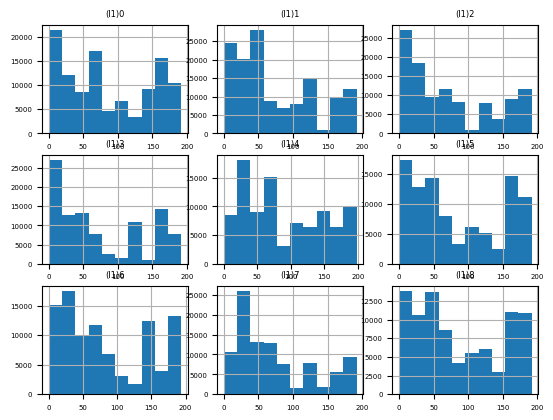

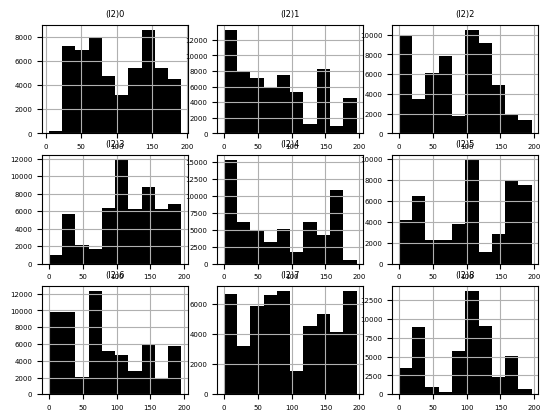

In [ ]:
layeranalyser(mdl)
CDATA

(<torch.utils.data.dataloader.DataLoader at 0x7d0d25597ee0>,
 <torch.utils.data.dataloader.DataLoader at 0x7d0d25928940>)

In [ ]:
print(mdl)

mymnist(
  (firstlayer): Linear(in_features=784, out_features=100, bias=True)
  (firstactive): ReLU()
  (secondlayer): Linear(in_features=100, out_features=50, bias=True)
  (secondactive): ReLU()
  (thirdlayer): Linear(in_features=50, out_features=10, bias=True)
  (final): LogSoftmax(dim=None)
)


[1, 2, 3, 2, 4, 5, 6]

In [ ]:
#####################################################################################

In [ ]:
image,lbl=next(iter(train7loader))
lbl[0].item()

7

In [ ]:
def extractres(model,dataloader):
  dig={}
  for i in range(10):
    dig[i]=0
  data=iter(dataloader)
  for (img,lbl) in dataloader:
    for i in range(len(lbl)):
      img1=img[i].view(1,28*28)
      with torch.no_grad():
        outs=model(img1)
      pred=torch.exp(outs).numpy().argmax(axis=1)
      if pred != lbl.numpy()[i]:
        #print(lbl[i].numpy())
        ind=lbl[i].item()
        dig[ind]=dig[ind]+1
  return dig

def grapher(digit):
  x=[]
  y=[]
  for i in range(10):
    x.append(i)
    y.append(digit[i])
  return y

#extractres(model,train7loader)

In [ ]:
cmodel=MNIST(28*28,[128,64])

BT=None
AT=None
AU=None

BT=extractres(cmodel,testloader)
cmodel.tester(testloader)

All= 10000; correct= 1135; Accuracy= 0.1135


In [ ]:
cmodel.tester(train7loader)

All= 6265; correct= 0; Accuracy= 0.0


In [ ]:
cmodel.trainer(trainloader)
cmodel.tester(testloader)
AT=extractres(cmodel,testloader)

epoch: 0 : loss= 903.9591459594667
epoch: 1 : loss= 413.988279257901
epoch: 2 : loss= 294.0819219844416
epoch: 3 : loss= 232.66723833302967
epoch: 4 : loss= 193.74084151536226
All= 10000; correct= 9671; Accuracy= 0.9671


In [ ]:
cmodel.tester(train7loader)

All= 6265; correct= 6045; Accuracy= 0.9648842777334398


In [ ]:
noise=cmodel.unlearn([7],trainloader)
noise=getnoisydata(noise,[7],trainset)
noisy=torch.utils.data.DataLoader(noise)
cmodel.trainer(noisy)
cmodel.trainer(smalltrainloader)
#cmodel.trainer(noisy)
cmodel.tester(testloader)
AU=extractres(cmodel,testloader)

Generating noise for class 7
epoch: 0 : loss= 1509.359633093915
epoch: 1 : loss= 1162.2941823323042
epoch: 2 : loss= 1136.1999943192109
epoch: 3 : loss= 853.1766371446707
epoch: 4 : loss= 873.6089599650197
epoch: 0 : loss= 65.3246055685166
epoch: 1 : loss= 39.16959888885403
epoch: 2 : loss= 39.42543239125953
epoch: 3 : loss= 27.378037466292838
epoch: 4 : loss= 30.21603142750392
All= 10000; correct= 6388; Accuracy= 0.6388


In [ ]:
cmodel.tester(train7loader)

All= 6265; correct= 0; Accuracy= 0.0


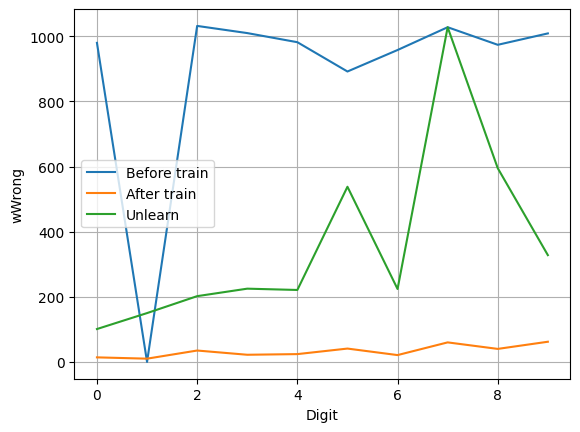

In [ ]:
bt,at,au=grapher(BT),grapher(AT),grapher(AU)
x=[0,1,2,3,4,5,6,7,8,9]
plt.plot(x,bt,label='Before train')
plt.plot(x,at,label='After train')
plt.plot(x,au,label='Unlearn')
plt.xlabel('Digit')
plt.ylabel('wWrong')
plt.grid(which='major')
plt.legend()

In [ ]:
noise=model.unlearn([7],train7loader)
noise=getnoisydata(noise,[7],trainset)
noisy=torch.utils.data.DataLoader(noise)

Generating noise for class 7


In [ ]:
model.trainer(noisy)
model.tester(train7loader)

epoch: 0 : loss= 1414.0141113119757
epoch: 1 : loss= 1071.414642028983
epoch: 2 : loss= 969.0185207223336
epoch: 3 : loss= 899.2069848383519
epoch: 4 : loss= 757.4094284287298
All= 6265; correct= 9; Accuracy= 0.0014365522745411015


In [ ]:
#plotter(model,testloader,4)

In [ ]:
noise=model.unlearn([7],trainloader)

Generating noise for class 7


epoch: 0 : loss= 111.21930613182485
epoch: 1 : loss= 29.35147646232508
epoch: 2 : loss= 25.14490424207179
epoch: 3 : loss= 22.40380856342381
epoch: 4 : loss= 20.240507430862635
All= 10000; correct= 2949; Accuracy= 0.2949


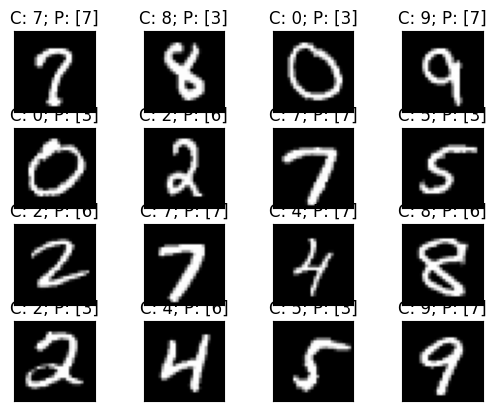

In [ ]:
#
customtrain=Customdata([7,3,6],trainset)
customloader=torch.utils.data.DataLoader(customtrain,batch_size=batch_size,shuffle=True)
cmodel=MNIST(28*28,[128,64])
cmodel.trainer(customloader)
cmodel.tester(testloader)
plotter(cmodel,testloader,4)

epoch: 0 : loss= 17.30737945018336
epoch: 1 : loss= 14.690388315619202
epoch: 2 : loss= 12.398024929163512
epoch: 3 : loss= 11.077298626842094
epoch: 4 : loss= 10.008129621135595
All= 10000; correct= 2965; Accuracy= 0.2965


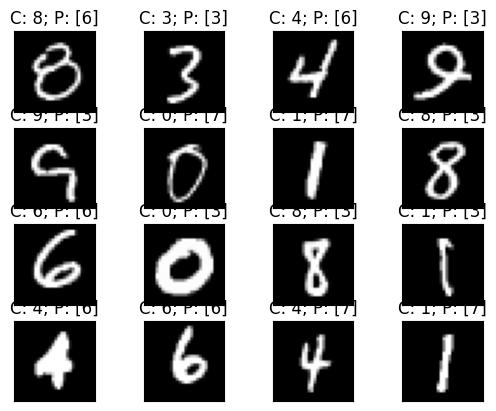

In [ ]:
customtrain2=Customdata([1,2,4],trainset)
customloader2=torch.utils.data.DataLoader(customtrain,batch_size=batch_size,shuffle=True)
cmodel.trainer(customloader2)
cmodel.tester(testloader)
plotter(cmodel,testloader,4)

epoch: 0 : loss= 856.3769882693887
epoch: 1 : loss= 384.3578100018203
epoch: 2 : loss= 293.51686745276675
epoch: 3 : loss= 240.9807339082472
epoch: 4 : loss= 207.68649458233267
All= 10000; correct= 9656; Accuracy= 0.9656


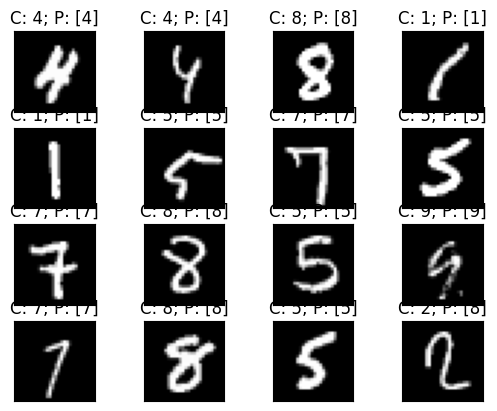

In [ ]:
cmodel.trainer(trainloader)
cmodel.tester(testloader)
plotter(cmodel,testloader,4)

In [ ]:
im,lb=next(iter(trainloader))
out=cmodel(im.view(im.shape[0],-1))
out.shape,lb.shape

(torch.Size([32, 10]), torch.Size([32]))

In [ ]:
out[0],lb[0]

(tensor([-1.8861e+01, -6.9923e+00, -1.0758e+01, -6.3739e+00, -1.5767e+01,
         -1.5096e+01, -2.7016e+01, -3.0597e-03, -1.4470e+01, -7.8032e+00],
        grad_fn=<SelectBackward0>),
 tensor(7))

In [ ]:
cmodel.unlearn([],testloader)

{}